In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme()

# Matrix size comparison

## Firmware dimensions

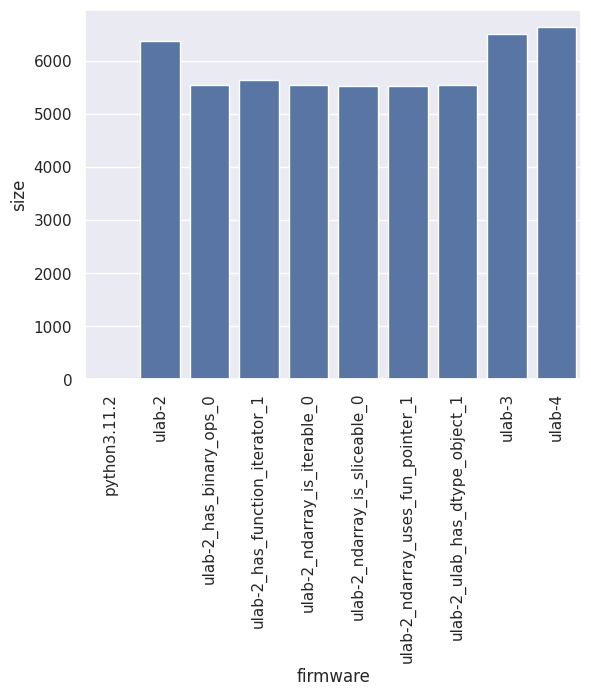

In [2]:
firmware_size = pd.read_csv("sizes.csv")
sns.barplot(data=firmware_size, x="firmware", y="size")
plt.xticks(rotation=90)
plt.show()

## Performance comparison

In [3]:
import os
from pathlib import Path

times_directory = Path("times")
firmwares = []
# for filename in os.listdir(times_directory):
for file in times_directory.iterdir():
	if not file.is_file() or not file.suffix == ".csv":
		continue
	times = pd.read_csv(str(file))
	times["firmware"] = file.stem
	firmwares.append(times)

times = pd.concat(firmwares)

times

# firmwares = {
# 	"python": pd.read_csv("times/[NUMPY] times.csv"),
# 	"2d": pd.read_csv("times/[ULAB] 2 times.csv"),
# 	"3d": pd.read_csv("times/[ULAB] 3 times.csv"),
# 	"4d": pd.read_csv("times/[ULAB] 4 times.csv"),
# }

,test name,id,time,firmware,valid
0,matrix multiplication,0,7.113955,python3.11.2,NaN
1,matrix multiplication,1,6.310904,python3.11.2,NaN
2,matrix multiplication,2,6.279800,python3.11.2,NaN
3,matrix multiplication,3,6.217649,python3.11.2,NaN
4,matrix multiplication,4,5.956244,python3.11.2,NaN
...,...,...,...,...,...
395,linear system,95,4.172000,ulab-2_ndarray_is_iterable_0,NaN
396,linear system,96,4.477000,ulab-2_ndarray_is_iterable_0,NaN
397,linear system,97,4.336000,ulab-2_ndarray_is_iterable_0,NaN
398,linear system,98,4.321000,ulab-2_ndarray_is_iterable_0,NaN


In [17]:
import json
import os
import pickle
import numpy as np

def load_results(file_path, load_pickle=False):
    if load_pickle:
        with open(file_path, "rb") as f:
            return pickle.load(f)
    else:
        with open(file_path, "r") as f:
            return json.load(f)

def is_close(result1, result2, rel_tol=1e-6, abs_tol=0.0):
    try:
        return np.allclose(result1, result2, rtol=rel_tol, atol=abs_tol)
    except TypeError:
        return result1 == result2


def compare_results(results1, results2):
    differences = {}
    for test_name in results1:
        if test_name not in results2:
            differences[test_name] = "Missing in second result set"
            continue
        result1 = results1[test_name]
        result2 = results2[test_name]
        if not is_close(result1, result2):
            differences[test_name] = "Results differ"
    for test_name in results2:
        if test_name not in results1:
            differences[test_name] = "Missing in first result set"
    return differences


# Path to the reference result file
reference_file = "python3.11.2.pkl"

results_directory = "results" 
reference_results = load_results(os.path.join("results", reference_file), load_pickle=True)

for root, dirs, files in os.walk(results_directory):
    for file in files:
        if file.endswith(".pkl") and file != reference_file:
            result_file = os.path.join(root, file)
            print(f"Comparing results in {result_file} with reference results...")
            results = load_results(result_file)
            differences = compare_results(reference_results, results)
            if differences:
                print(f"Differences found in {result_file}:")
                for test_name, difference in differences.items():
                    print(f"  {test_name}: {difference}")
            else:
                print(f"No differences found in {result_file}.")



Comparing results in results/ulab-3.pkl with reference results...
Differences found in results/ulab-3.pkl:
  interpolation: Results differ
  fft: Results differ
  linear system: Results differ
Comparing results in results/ulab-2_ndarray_uses_fun_pointer_1.pkl with reference results...
Differences found in results/ulab-2_ndarray_uses_fun_pointer_1.pkl:
  interpolation: Results differ
  fft: Results differ
  linear system: Results differ
Comparing results in results/ulab-4.pkl with reference results...
Differences found in results/ulab-4.pkl:
  interpolation: Results differ
  fft: Results differ
  linear system: Results differ
Comparing results in results/ulab-2.pkl with reference results...
Differences found in results/ulab-2.pkl:
  interpolation: Results differ
  fft: Results differ
  linear system: Results differ
Comparing results in results/ulab-2_ndarray_is_iterable_0.pkl with reference results...
Differences found in results/ulab-2_ndarray_is_iterable_0.pkl:
  interpolation: Result

In [5]:
# invalid = times.loc[times["valid"] == False]
# invalid_firmwares = invalid["firmware"].unique()
# print(f"there are {len(invalid)} invalid tests from the firmwares:{invalid_firmwares}")

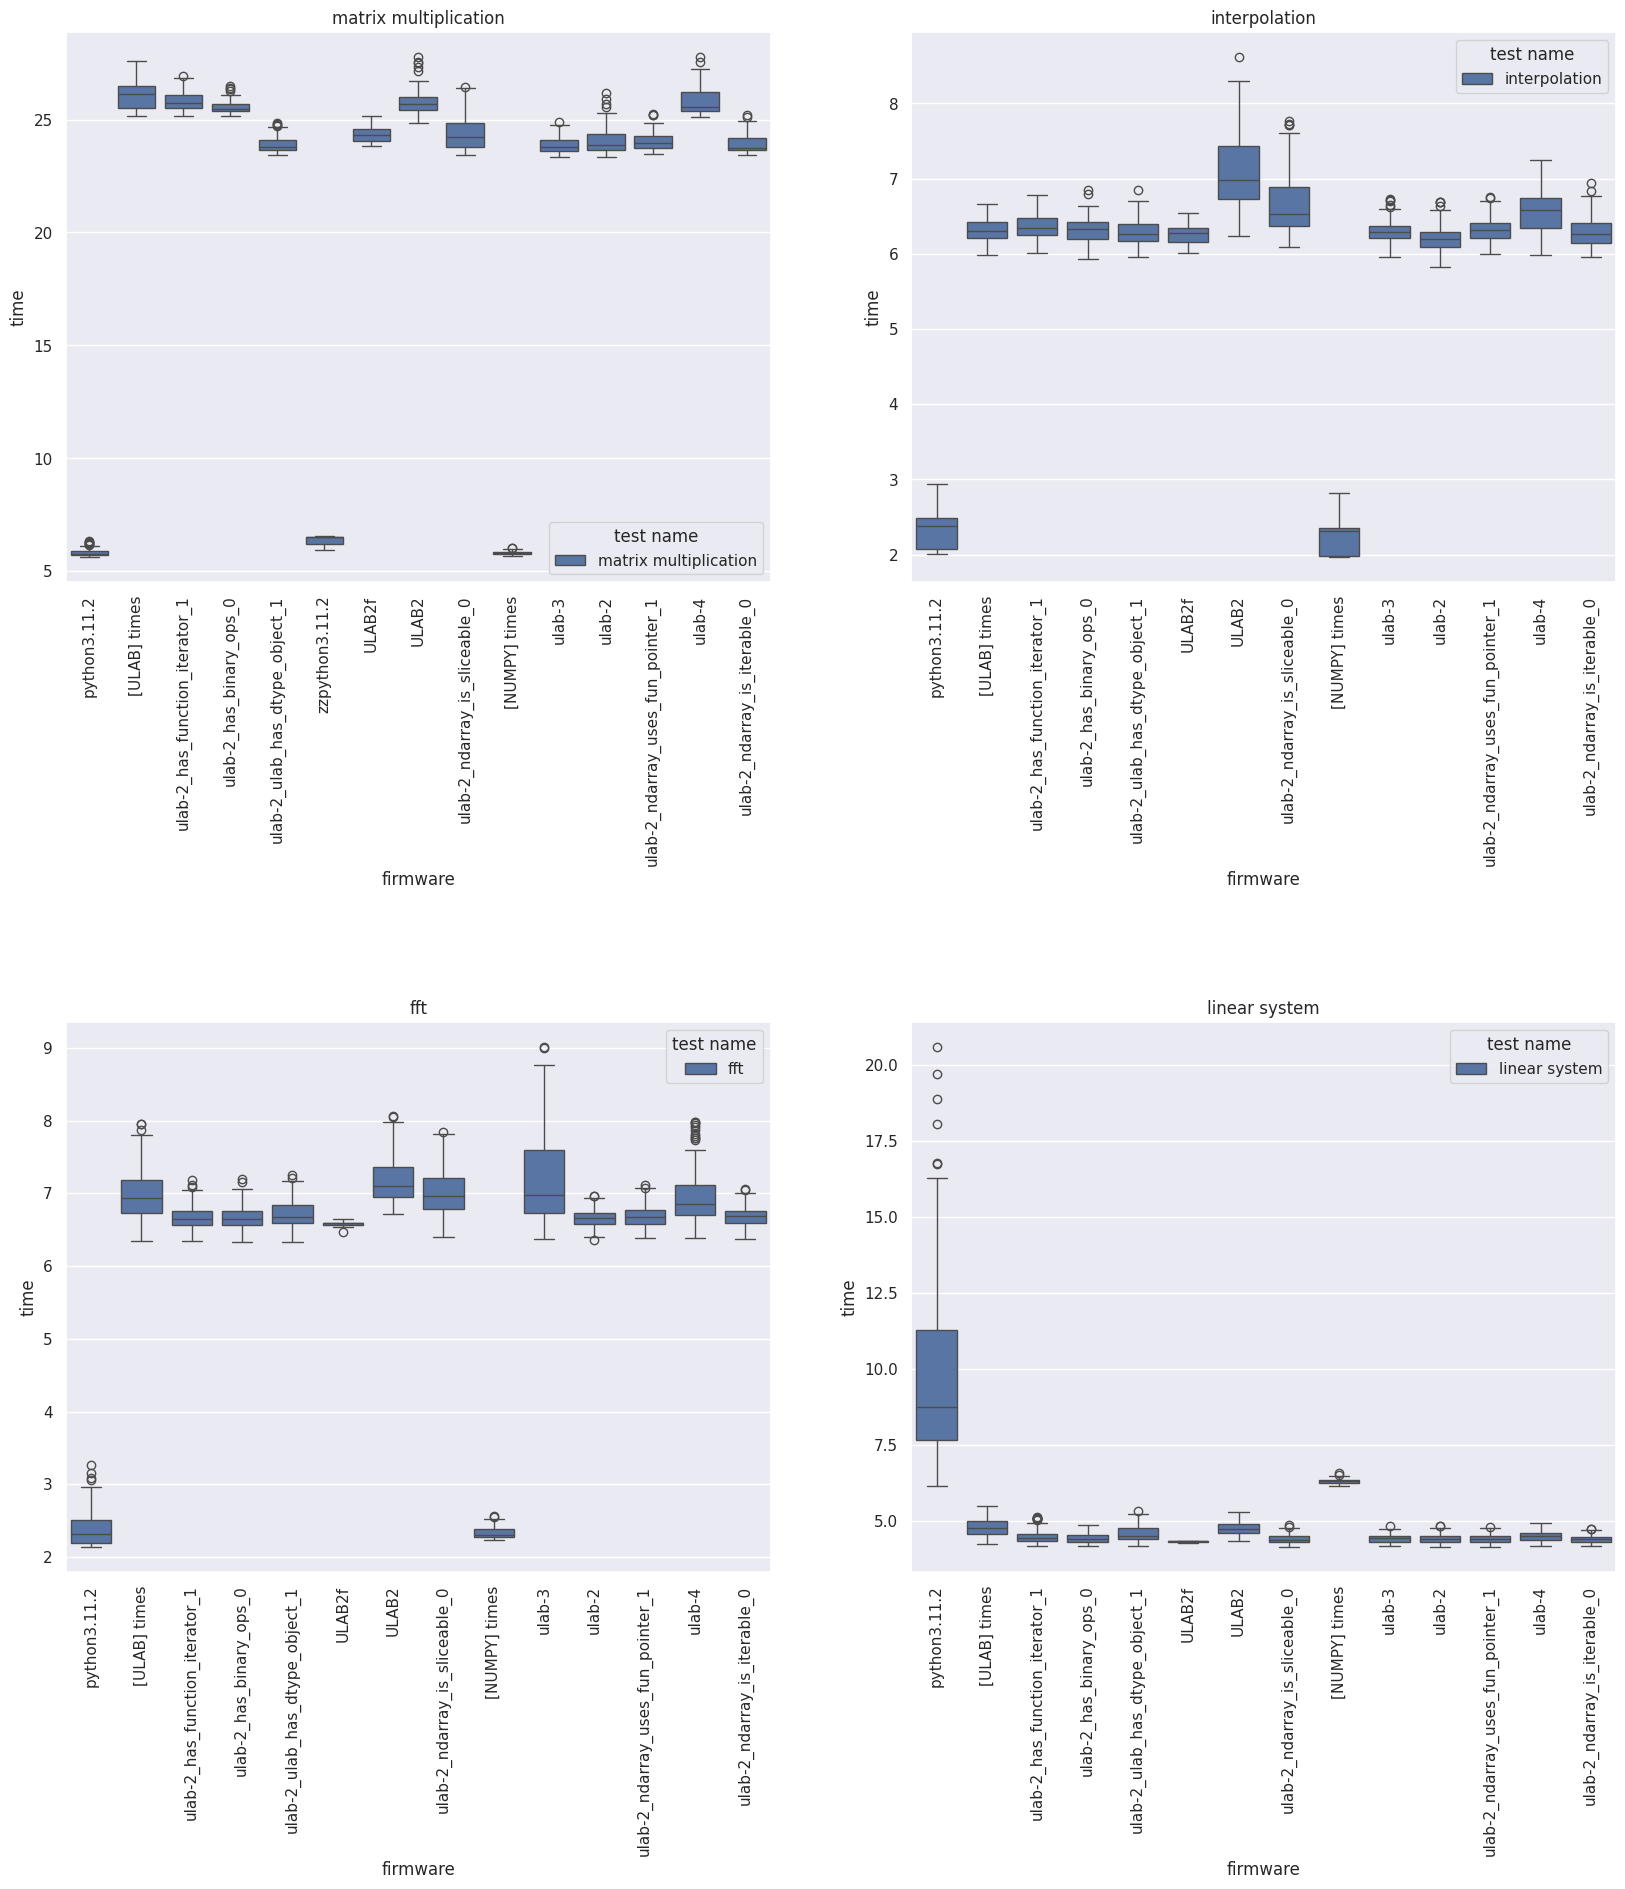

In [6]:
import math

# follows the iqr (interquantile range rule)
def remove_outliers(df, column):
    firmwares = df["firmware"].unique()
    bounded = []
    for f in firmwares:
        f_data = df.loc[df["firmware"] == f]
        Q1 = f_data[column].quantile(0.25)
        Q3 = f_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        bounded.append(f_data.loc[(f_data[column] >= lower_bound) & (f_data[column] <= upper_bound)])
    return pd.concat(bounded)

columns = 2
tests = times["test name"].unique()
fig, axes = plt.subplots(2, math.ceil(float(len(tests)) / 2), figsize=(20, 20))
for test, ax in zip(tests, axes.flatten()):
    test_data = times.loc[times["test name"] == test]
    no_outliers = remove_outliers(test_data, "time")
    ax.tick_params(axis="x", rotation=90)
    sns.boxplot(data=no_outliers, ax=ax, x="firmware", y="time", hue="test name")
    ax.set_title(test)

plt.subplots_adjust(hspace=0.8) 
plt.show()

In [7]:
aggregate = times.groupby(['firmware', 'test name'])["time"].agg(["min", "max", "median", "std"]).reset_index()
aggregate

,firmware,test name,min,max,median,std
0,ULAB2,fft,6.720000,8.698000,7.131000,0.419700
1,ULAB2,interpolation,6.238000,11.579000,7.029000,0.778501
2,ULAB2,linear system,4.333000,5.769000,4.750500,0.258078
3,ULAB2,matrix multiplication,24.831000,33.537000,25.837000,1.861348
4,ULAB2f,fft,6.394000,6.737000,6.584500,0.092912
5,ULAB2f,interpolation,6.014000,6.543000,6.278500,0.153029
6,ULAB2f,linear system,4.277000,4.475000,4.338500,0.066123
7,ULAB2f,matrix multiplication,23.839000,31.983000,24.427500,2.441400
8,[NUMPY] times,fft,2.230524,2.853497,2.302097,0.128128
9,[NUMPY] times,interpolation,1.967947,2.821182,2.320753,0.216738
